# K-Nearrest Neighbors

## Tasks

### Create a k-NN classifier with PCA. Tune k and the distance metric
* Encapsulate your KNeighborsClassifier into a Pipeline object with a  PCA preprocessing step
* Set the number of components using your scree plot, e.g., select the number of components to retain 90% of the variance explained
* Split the train set (4,000 points) into a (smaller) train and validation sets with respectively 3,200 and 800 samples. Tune k and the distance metric (try 
L1 and L2) using grid search on these train and validation sets
* Create a k-NN classifier for each combination of parameter in the grid, fit it to the train set and evaluate it on the validation set**
* Print the accuracy of each combination of parameters on the validation set - using a DataFrame for instance
* Find (using code) the combination with the best validation accuracy and print it
* Fit your k-NN classifier with the tuned parameters to the entire train data with the 4,000 data points and evaluate its accuracy on the test set, i.e., the remaining 1,000 labeled points


### Choose an image from the test set and plot its 10 nearest neighbors
* Extract the PCA transformer and the  KNeighborsClassifier estimator from your pipeline
* Apply PCA to your test image and pass the result to the kneighbors(X, n_neighbors) function of your k-NN estimator
* Use the indexes to extract the pixels of the ten images from the matrix of pixels and plot them with the imshow() function


## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import random

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# Activate Seaborn style
sns.set()

## Import data

In [2]:
# Load the npz file
with np.load('Cifar4-train.npz', allow_pickle=False) as cifar_df:
    # It's a dictionary-like object
    cifar4 = dict(cifar_df.items())

In [3]:
X=cifar4['overfeat']
Xp=cifar4['pixels']
y=cifar4['labels']
names=cifar4['names']

print(X.shape, X.dtype)
print(Xp.shape, Xp.dtype)
print(y.shape, y.dtype)
print(names.shape, names.dtype)

(5000, 4096) float32
(5000, 3072) uint8
(5000,) int64
(4,) <U8


## Create X/y arrays

In [4]:
# Convert the type of the input matrix to float
X = X.astype(np.float)
Xp=Xp.astype(np.float)

# Create train set
X_tr_main, X_test, Xp_tr_main, Xp_test, y_tr_main, y_test = train_test_split(X, Xp, y, test_size=1000, random_state=0)

# Create validation and test sets
X_tr_2nd, X_valid, Xp_tr_2nd, Xp_valid ,y_tr_2nd, y_valid = train_test_split(
    X_tr_main, Xp_tr_main, y_tr_main, test_size=800, random_state=0)

print('Train:', X_tr_main.shape, y_tr_main.shape)
print('Test:', X_test.shape, y_test.shape)
print('Train2:', X_tr_2nd.shape, y_tr_2nd.shape)
print('Valid:', X_valid.shape, y_test.shape)
print('Train_p:', Xp_tr_main.shape)
print('test_p:',Xp_test.shape)

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
Train2: (3200, 4096) (3200,)
Valid: (800, 4096) (1000,)
Train_p: (4000, 3072)
test_p: (1000, 3072)


In [5]:
# Image distribution y_tr
pd.value_counts(y_tr_main, normalize=True)

1    0.25575
2    0.25075
3    0.24800
0    0.24550
dtype: float64

In [6]:
# Image distribution y_te
pd.value_counts(y_test, normalize=True)

0    0.268
3    0.258
2    0.247
1    0.227
dtype: float64

In [7]:
# Image distribution y_te
pd.value_counts(y_tr_2nd, normalize=True)

1    0.259688
3    0.250625
2    0.247500
0    0.242188
dtype: float64

In [8]:
# Image distribution y_te
pd.value_counts(y_valid, normalize=True)

2    0.26375
0    0.25875
1    0.24000
3    0.23750
dtype: float64

* Distribution of images is balanced across train/test samples (As Scikit Learn default stratify parameter uses class labels)

## Create a pipeline for performing the K-NN
* Data exploration part shows that 90% of the variance (applying PCA) could be explained with 175 components

### Create K-NN classifier pipeline

In [9]:
# Create k-NN classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # with standardization
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        n_jobs=-1, # As many parallel jobs as possible
    ))
])

### Define key parameters for the K-NN

In [10]:
# Grid of parameters
grid = ParameterGrid({
    'knn__n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40], # k
    'knn__weights': ['uniform', 'distance'], # Weighting function
    'knn__p': [1, 2], # L1 and L2 distance metrics
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 32


### Run the K-NN model on sub-train data set (3200 data points) and test accuracy on the validation data set (800 data points)

In [11]:
# Save accuracy on test set
valid_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr_2nd, y_tr_2nd) # Train2 3200 data points

    # Save accuracy on validation set
    params_dict['accuracy'] = pipe.score(X_valid, y_valid)

    # Save result
    valid_scores.append(params_dict)

print('done')

Combination 1/32
Combination 2/32
Combination 3/32
Combination 4/32
Combination 5/32
Combination 6/32
Combination 7/32
Combination 8/32
Combination 9/32
Combination 10/32
Combination 11/32
Combination 12/32
Combination 13/32
Combination 14/32
Combination 15/32
Combination 16/32
Combination 17/32
Combination 18/32
Combination 19/32
Combination 20/32
Combination 21/32
Combination 22/32
Combination 23/32
Combination 24/32
Combination 25/32
Combination 26/32
Combination 27/32
Combination 28/32
Combination 29/32
Combination 30/32
Combination 31/32
Combination 32/32
done


### Print the results of the best model parameters based on level of accuracy

In [12]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(valid_scores)

# Print scores
scores_df.sort_values(by='accuracy', ascending=False)

,knn__n_neighbors,knn__p,knn__weights,accuracy
19,25,2,distance,0.79750
18,25,2,uniform,0.79125
15,20,2,distance,0.79000
25,35,1,distance,0.78625
14,20,2,uniform,0.78500
13,20,1,distance,0.78375
27,35,2,distance,0.78250
16,25,1,uniform,0.78125
23,30,2,distance,0.78125
22,30,2,uniform,0.78125


### Print the best estimator parameters

In [13]:
# Find best combination
idx = np.argmax(scores_df['accuracy'])
print('Top validation accuracy on set {:}'.format(idx))

print('Accuracy on validation set: {:.3f}'.format(
     scores_df.accuracy[idx]
     ))

# Print n neighbors
print('n_neighbors: {:}'.format(
    scores_df.knn__n_neighbors[idx], 
))

# Print distance metric
print('Distance metrix: {:}'.format(
    scores_df.knn__p[idx], 
))

# Print weight function
print('Weight function: {:}'.format(
    scores_df.knn__weights[idx], 
))


Top validation accuracy on set 19
Accuracy on validation set: 0.797
n_neighbors: 25
Distance metrix: 2
Weight function: distance


### Run the Best K-NN model on the full train data set (4000 data points) and test its accuracy on the test data set (1000 data points)
* **Best Model (Accuracy = 0.791): n_neighbors 25, L2 distance metrics and uniform weight function**

#### Create the K-NN classifier with Best results

In [14]:
# Create k-NN classifier
pipe2 = Pipeline([
    ('scaler', StandardScaler()), # with standardization
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('knn', KNeighborsClassifier(
        n_neighbors=25,
        weights='distance',
        p=2,
        leaf_size=30,
        algorithm='brute', # Brute-force search
        n_jobs=-1 # As many parallel jobs as possible
    ))
])

In [15]:
# Save accuracy on test set
test_scores1 = []

# Fit a k-NN classifier
pipe2.fit(X_tr_main, y_tr_main) # Train2 3800 data points

# Save accuracy on test set
params_dict['accuracy'] = pipe2.score(X_test, y_test)

# Save result
test_scores1.append(params_dict)

print(test_scores1)

[{'knn__n_neighbors': 40, 'knn__p': 2, 'knn__weights': 'distance', 'accuracy': 0.781}]


#### **Accuracy of the baseline model (K-NN) = 0.785**

### Save the results of the Baseline

In [16]:
Baseline_K_NN=0.785
%store Baseline_K_NN

Stored 'Baseline_K_NN' (float)


## Choose an image from the test set and plot its 10 nearest neighbors
* Extract the PCA transformer and the  KNeighborsClassifier estimator from your pipeline
* Apply PCA to your test image and pass the result to the kneighbors(X, n_neighbors) function of your k-NN estimator
* Use the indexes to extract the pixels of the ten images from the matrix of pixels and plot them with the imshow() function

#### Select an image from the test set

In [17]:
# Select an image from the Overfeat and Pixels Test data set
img1_over=X_test[50, :] # 51th row from Overfeat
flat_img1_pix=Xp_test[50, :] # 51th row from Pixels

In [18]:
img1_over.shape

(4096,)

In [19]:
# Reshape the image
img1_re=img1_over.reshape(1,-1)

In [20]:
img1_re.shape

(1, 4096)

### Visualize the selected image

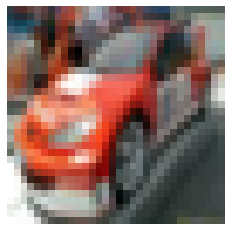

In [21]:
# Print the image from Test Pixels

# Reshape the image
img1_pix = flat_img1_pix.reshape(32, 32, 3)

# Plot the rescaled image
plt.imshow(img1_pix/255)
plt.axis('off')
plt.show()

#### Apply Best estimator parameters to the selected image

In [22]:
# Rescale overfeatures of test set image
scaler3 = pipe2.named_steps['scaler'] 
img1_over_resc = scaler3.transform(img1_re)

In [23]:
# apply PCA:
pca3 = pipe2.named_steps['PCA'] 
img1_over_pca = pca3.transform(img1_over_resc)

In [24]:
# Get KNN trained model:
knn3 = pipe2.named_steps['knn']

In [25]:
# Get the 10 neighbors parameters
ten_neighb_dist, ten_neighb_idx= knn3.kneighbors(img1_over_pca, 10, return_distance=True)

In [26]:
ten_neighb_dist

array([[58.41668456, 64.58561598, 66.54093342, 66.79281354, 66.85458539,
        67.227499  , 67.71266505, 67.87884716, 67.89264886, 68.17599445]])

In [27]:
ten_neighb_idx

array([[1477, 1324, 1782, 1381, 2486, 2295,  350, 3067, 2313,  757]],
      dtype=int64)

#### Check parameters consistency with selected estimators

In [28]:
knn3.get_params()

{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 25,
 'p': 2,
 'weights': 'distance'}

#### Vissualize one of the image

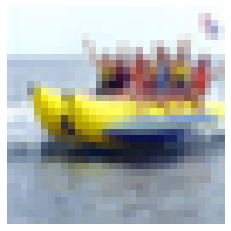

In [29]:
pix1=Xp_test[350,:]

# Reshape the image
pixn = pix1.reshape(32, 32, 3)

# Plot the rescaled image
plt.imshow(pixn/255)
plt.axis('off')
plt.show()